# Анализ датасета неисправности стальных плат 'Faulty-steel-plates' с kaggle: 
(ссылка - https://www.kaggle.com/uciml/faulty-steel-plates)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as st
import statsmodels as sm
import matplotlib
import pandas as pd
import io
import requests
import seaborn as sns
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
# Загружаю датасет из Kaggle
!kaggle datasets download -d uciml/faulty-steel-plates

faulty-steel-plates.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
data_temp=pd.read_csv('gt.zip/faults.csv')
data_temp.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [4]:
data_temp.shape

(1941, 34)

In [5]:
# во всех атрибутах все данные заполнены
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 34 columns):
X_Minimum                1941 non-null int64
X_Maximum                1941 non-null int64
Y_Minimum                1941 non-null int64
Y_Maximum                1941 non-null int64
Pixels_Areas             1941 non-null int64
X_Perimeter              1941 non-null int64
Y_Perimeter              1941 non-null int64
Sum_of_Luminosity        1941 non-null int64
Minimum_of_Luminosity    1941 non-null int64
Maximum_of_Luminosity    1941 non-null int64
Length_of_Conveyer       1941 non-null int64
TypeOfSteel_A300         1941 non-null int64
TypeOfSteel_A400         1941 non-null int64
Steel_Plate_Thickness    1941 non-null int64
Edges_Index              1941 non-null float64
Empty_Index              1941 non-null float64
Square_Index             1941 non-null float64
Outside_X_Index          1941 non-null float64
Edges_X_Index            1941 non-null float64
Edges_Y_Index            194

В данном датасете 34 атрибута. Первые 27 атрибутов описывают некоторые неиправности стальной платы, которые были замечены в изображениях.

*    X_Minimum
*    X_Maximum
*    Y_Minimum
*    Y_Maximum
*    Pixels_Areas
*    X_Perimeter
*    Y_Perimeter
*    Sum_of_Luminosity
*    Minimum_of_Luminosity
*    Maximum_of_Luminosity
*    Length_of_Conveyer
*    TypeOfSteel_A300
*    TypeOfSteel_A400
*    Steel_Plate_Thickness
*    Edges_Index
*    Empty_Index
*    Square_Index
*    Outside_X_Index
*    Edges_X_Index
*    Edges_Y_Index
*    Outside_Global_Index
*    LogOfAreas
*    Log_X_Index
*    Log_Y_Index
*    Orientation_Index
*    Luminosity_Index
*    SigmoidOfAreas

Последние 7 колонок - это класс, к которому относится то или иное повреждение (one-hot-encoding). Например, если какой-либо элемент классифицируется как "Stains" (пятна), то в колонке 'Stains' 
будет стоять единица.

*    Pastry
*    Z_Scratch
*    K_Scatch
*    Stains
*    Dirtiness
*    Bumps
*    Other_Faults

Первые 27 колонок данной таблицы являются колонками для предсказаний класса.

In [6]:
data = data_temp.iloc[:,:27]
data.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,42,50,270900,270944,267,17,44,24220,76,108,...,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822
1,645,651,2538079,2538108,108,10,30,11397,84,123,...,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984
2,829,835,1553913,1553931,71,8,19,7972,99,125,...,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150
3,853,860,369370,369415,176,13,45,18996,99,126,...,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212
4,1289,1306,498078,498335,2409,60,260,246930,37,126,...,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000


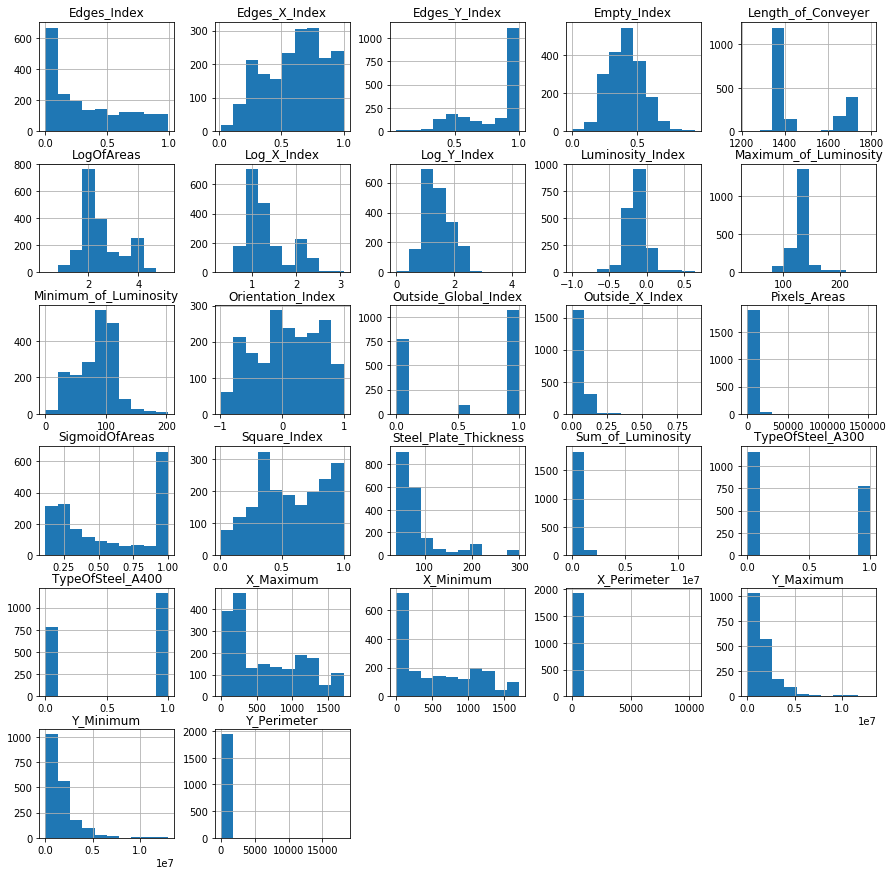

In [7]:
# Гистограммы распределения всех атрибутов
data.hist(figsize=(15,15))
plt.show()

In [8]:
# Нормализую параметры
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=[-1,1])
np_scaled = min_max_scaler.fit_transform(data)
data_norm = pd.DataFrame(np_scaled)
data_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


In [9]:
# Возвращаю названия столбцов
data_norm.columns = list(data.columns)
data_norm.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.946167,-0.959296,-0.959291,-0.996528,-0.997128,-0.995262,-0.995864,-0.251232,-0.342593,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.242832,-0.609987,-0.609985,-0.998611,-0.998468,-0.996805,-0.998077,-0.172414,-0.203704,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.027501,-0.761620,-0.761619,-0.999096,-0.998851,-0.998017,-0.998668,-0.024631,-0.185185,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,0.001755,-0.944125,-0.944120,-0.997720,-0.997894,-0.995152,-0.996765,-0.024631,-0.175926,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,0.523698,-0.924294,-0.924257,-0.968464,-0.988896,-0.971462,-0.957437,-0.635468,-0.175926,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


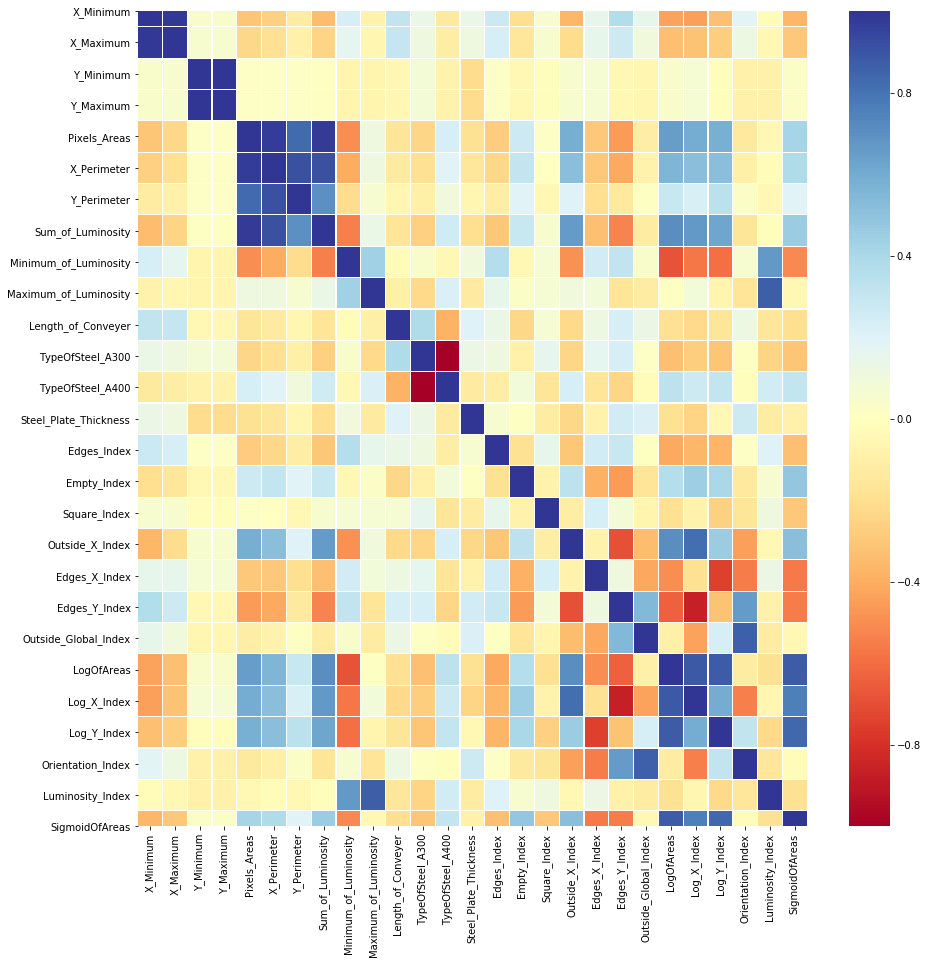

In [10]:
# Матрица корреляций атрибутов
plt.subplots(figsize=(15, 15))
corr = np.round_(data_norm.corr(), decimals=2)
sns.heatmap(corr,annot=False,cmap='RdYlBu',linewidths=0.1)

#### Построю графики boxplot по каждому атрибуту

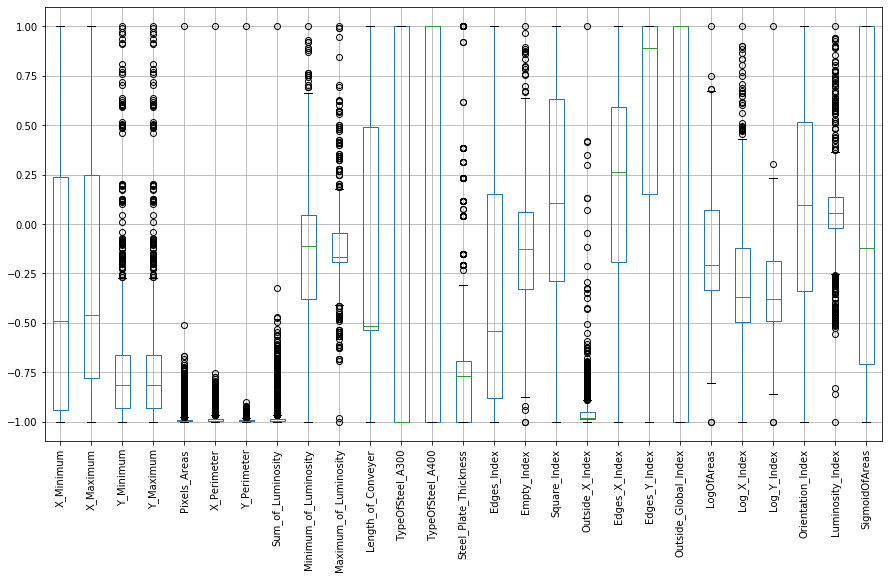

In [11]:
# По некоторым атрибутам есть значительные выбросы.
boxplot = data_norm.boxplot(figsize=(15,8), rot=90)

Отчищу данные от выбросов и посмотрю, удалив данные, которые меньше 5% квантиля и больше 95% квантиля

In [12]:
low = .05
high = .95
quantiles = data_norm.quantile([low, high])
quantiles

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0.05,-0.983578,-0.970743,-0.987665,-0.987660,-0.999515,-0.998660,-0.999339,-0.999293,-0.714286,-0.398148,...,-0.993367,-0.60207,-0.300967,-1.0,-0.471563,-0.655836,-0.671731,-0.677510,-0.206581,-0.885131
0.95,0.804106,0.822118,-0.302638,-0.302637,-0.853144,-0.882454,-0.958129,-0.776846,0.221675,0.101852,...,-0.708600,1.00000,1.000000,1.0,0.535462,0.400599,0.047456,0.844152,0.263254,1.000000


In [13]:
quantile_norm = data_norm.apply(lambda col: col[(col >= quantiles.loc[low,col.name]) & 
                                    (col <= quantiles.loc[high,col.name])], axis=0)

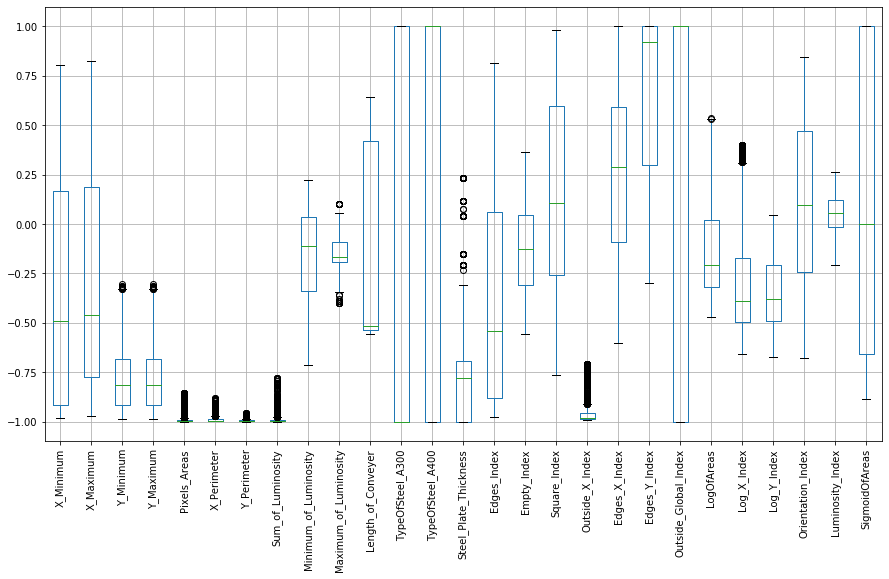

In [87]:
# Выбросы остались, но они не столь критичны
boxplot = quantile_norm.boxplot(figsize=(15,8), rot=90)

### Уменьшу количество атрибутов, удалив те, которые имеет корреляцию, большей чем 95%, чтобы уйти от мультиколлинеарности

In [15]:
# матрица корреляций
corr_matrix = data_norm.corr().abs()

# Оставляю только верхний треугольник матрицы (чтобы удалить только один из коррелирующих столбцов)
under = corr_matrix*(np.triu(np.ones(corr_matrix.shape), k=1))

# Нахожу колонки с корреляцией большей чем 0.95
to_drop = [column for column in under.columns if any(under[column] > 0.95)]

print(to_drop)

['X_Maximum', 'Y_Maximum', 'X_Perimeter', 'Sum_of_Luminosity', 'TypeOfSteel_A400']


In [16]:
data_norm = data_norm.drop(data_norm[to_drop], axis=1)
data_norm.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,...,-0.992681,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,...,-0.995197,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,...,-0.994968,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,...,-0.991537,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,...,-0.974611,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000


In [17]:
data_norm.shape

(1941, 22)

### Подготовлю данные для анализа (перевод в цифровой формат target значение и разбиение на тестовые и тренировочные)

In [18]:
output_y = data_temp.iloc[:,27:]
input_x = data_norm

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
le=LabelEncoder()
targets=output_y.idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

Other_Faults    673
Bumps           402
K_Scatch        391
Z_Scratch       190
Pastry          158
Stains           72
Dirtiness        55
dtype: int64


Раздуляю данные на тренировочные и тестовые

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.3)

## Применю классификационные модели машинного обучения Random Forest, Логистическая регрессия и SVC

### Модель деревья решений (Random Forest)

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
model = RandomForestClassifier(n_estimators=100)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       138
           1       0.84      0.94      0.89        17
           2       0.99      0.95      0.97       103
           3       0.65      0.79      0.71       193
           4       0.77      0.43      0.55        53
           5       0.91      0.95      0.93        22
           6       0.91      0.84      0.87        57

    accuracy                           0.77       583
   macro avg       0.83      0.80      0.80       583
weighted avg       0.78      0.77      0.77       583

Точность прогноза (accuracy) 77.2%


### Модель Логистической регрессии

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [118]:
model = LogisticRegression()

model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [119]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.71      0.54      0.61       138
           1       0.67      0.47      0.55        17
           2       0.89      0.94      0.92       103
           3       0.58      0.71      0.64       193
           4       0.77      0.43      0.55        53
           5       0.78      0.95      0.86        22
           6       0.78      0.89      0.84        57

    accuracy                           0.70       583
   macro avg       0.74      0.71      0.71       583
weighted avg       0.71      0.70      0.70       583

Точность прогноза (accuracy) 70.5%


In [137]:
from sklearn.naive_bayes import GaussianNB as GNB

### Метод опорных векторов SVC

In [140]:
from sklearn.svm import SVC

In [141]:
model = SVC()

model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.69      0.63      0.66       138
           1       1.00      0.29      0.45        17
           2       0.98      0.92      0.95       103
           3       0.57      0.74      0.64       193
           4       0.81      0.25      0.38        53
           5       0.71      0.91      0.80        22
           6       0.79      0.86      0.82        57

    accuracy                           0.70       583
   macro avg       0.79      0.66      0.67       583
weighted avg       0.73      0.70      0.69       583

Точность прогноза (accuracy) 70.5%


## Классы не сбалансированы. Увеличу количество элементов для уравновешивания классов.

In [120]:
from imblearn.over_sampling import RandomOverSampler

In [121]:
ros = RandomOverSampler(random_state=0)

ros.fit(X_train, y_train)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

print('Количество элементов до операции:', len(X_train))
print('Количество элементов после операции:', len(X_resampled))

Количество элементов до операции: 1358
Количество элементов после операции: 3360


In [122]:
unique, counts = np.unique(y_resampled, return_counts=True)
dict(zip(unique, counts))

{0: 480, 1: 480, 2: 480, 3: 480, 4: 480, 5: 480, 6: 480}

### Модель деревья решений (Random Forest) со сбалансированными классами

In [123]:
model=RandomForestClassifier(n_estimators=100)

model.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [124]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       138
           1       0.89      0.94      0.91        17
           2       0.99      0.97      0.98       103
           3       0.69      0.70      0.69       193
           4       0.68      0.64      0.66        53
           5       0.88      0.95      0.91        22
           6       0.89      0.89      0.89        57

    accuracy                           0.77       583
   macro avg       0.81      0.83      0.82       583
weighted avg       0.77      0.77      0.77       583

Точность прогноза (accuracy) 77.2%


### Модель Логистической регрессии со сбалансированными классами

In [125]:
model = LogisticRegression()

model.fit(X_resampled, y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [126]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       138
           1       0.37      0.94      0.53        17
           2       0.88      0.95      0.92       103
           3       0.79      0.40      0.53       193
           4       0.46      0.72      0.56        53
           5       0.76      1.00      0.86        22
           6       0.62      0.93      0.74        57

    accuracy                           0.67       583
   macro avg       0.65      0.80      0.68       583
weighted avg       0.71      0.67      0.66       583

Точность прогноза (accuracy) 67.1%


### Метод опорных векторов (SVC) со сбалансированными данными

In [144]:
model = SVC()

model.fit(X_resampled, y_resampled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [145]:
model_pred = model.predict(X_test)

print(classification_report(y_test, model_pred))

print(f'Точность прогноза (accuracy) {round(model.score(X_test, y_test)*100, 1)}%')

              precision    recall  f1-score   support

           0       0.64      0.77      0.70       138
           1       0.48      0.94      0.64        17
           2       0.93      0.95      0.94       103
           3       0.84      0.49      0.62       193
           4       0.54      0.75      0.63        53
           5       0.75      0.95      0.84        22
           6       0.76      0.88      0.81        57

    accuracy                           0.73       583
   macro avg       0.71      0.82      0.74       583
weighted avg       0.76      0.73      0.72       583

Точность прогноза (accuracy) 72.9%


In [127]:
# Mодель Random Forest показала результат лучше, чем модель логистической регрессии и SVC
# Использовать сбалансированность классов в Random Forest не было смысла

### Воспользуюсь кросс валидацией для улучшения работы алгоритма Random Forest

In [128]:
# Объединю нормированный данные с атрибутами для предсказания и сами данные о неисправленности
data_norm_target = input_x.join(pd.DataFrame(Y, columns=['target']))
data_norm_target.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,-0.950733,-0.959296,-0.996528,-0.995262,-0.251232,-0.342593,0.622575,1.0,-0.692308,-0.899920,...,-0.074269,1.000000,1.0,-0.129375,-0.565757,-0.228168,0.824986,-0.137599,0.051532,4
1,-0.243402,-0.609987,-0.998611,-0.996805,-0.172414,-0.203704,0.622575,1.0,-0.692308,0.536777,...,0.188312,0.930013,1.0,-0.290393,-0.655836,-0.313218,0.799667,0.003413,-0.592736,4
2,-0.027566,-0.761620,-0.999096,-0.998017,-0.024631,-0.185185,0.396825,1.0,-0.538462,0.951367,...,0.492695,0.889449,1.0,-0.364982,-0.655836,-0.410477,0.672164,0.067764,-0.782066,4
3,0.000587,-0.944125,-0.997720,-0.995152,-0.024631,-0.175926,-0.555556,-1.0,0.923077,0.464429,...,0.063515,1.000000,1.0,-0.203514,-0.607587,-0.223613,0.851415,0.026325,-0.086947,4
4,0.512023,-0.924294,-0.968464,-0.971462,-0.635468,-0.175926,-0.555556,-1.0,0.115385,-0.860330,...,-0.454343,0.975830,1.0,0.261925,-0.329631,0.131754,0.941595,-0.025350,1.000000,4


In [129]:
# Перемешаю все элементы
shuffled = data_norm_target.sample(frac=1)
shuffled = shuffled.reset_index(drop=True)
shuffled.head()

,X_Minimum,Y_Minimum,Pixels_Areas,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,Steel_Plate_Thickness,Edges_Index,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,target
0,-0.951906,-0.585312,-0.917132,-0.983803,-0.605911,-0.175926,-0.537919,-1.0,-1.000000,-0.878617,...,0.276786,-0.221311,-1.0,0.433715,0.404205,-0.158241,-0.655722,-0.007678,1.000000,2
1,-0.215249,-0.925300,-0.985654,-0.985455,-0.507389,-0.101852,0.622575,-1.0,-0.153846,0.593850,...,-0.513393,0.984237,1.0,0.122002,-0.368865,-0.004109,0.893781,0.036197,1.000000,4
2,0.459238,-0.992142,-0.991523,-0.992287,-0.162562,-0.259259,-0.530864,-1.0,-1.000000,-0.766479,...,-0.346591,0.319252,1.0,0.028611,-0.086077,-0.210463,0.230847,-0.092626,0.999773,3
3,0.350147,-0.867563,-0.998913,-0.998898,0.093596,-0.101852,-0.403880,-1.0,-0.384615,-0.326367,...,0.565138,1.000000,0.0,-0.332992,-0.466013,-0.510931,-0.000353,0.142474,-0.748014,3
4,-0.990616,-0.885235,-0.993200,-0.992728,-0.576355,-0.620370,-0.537919,1.0,-0.769231,-0.976286,...,-0.264002,0.905843,1.0,-0.010466,-0.235008,-0.151760,0.645836,-0.425350,0.999092,6


In [130]:
from sklearn import metrics

In [134]:
# Разделю датасет на 10 частей.
part = len(shuffled)//10

model=RandomForestClassifier(n_estimators=100)

mean_score = 0
for i in range(10):
    test = shuffled[i*part:(i+1)*part]
    train = shuffled.drop(shuffled.index[i*part:(i+1)*part])
    train_x = train.drop(['target'], axis=1)
    train_y = train.target
    test_x = test.drop(['target'], axis=1)
    test_y = test.target
    model.fit(train_x, train_y)

    model_pred = model.predict(test_x)
    mean_score += metrics.accuracy_score(test_y, model_pred)
    
print(f'Точность прогноза (accuracy) {round((mean_score/10)*100, 1)}%')

Точность прогноза (accuracy) 78.2%


После применения кросс-валидации точность прогноза увеличилась, модель качественней осуществляет прогноз.

In [146]:
print(f'Итоговая точность прогноза обученного алгоритма: {round((mean_score/10)*100, 1)}%')

Итоговая точность прогноза обученного алгоритма: 78.2%
